In [6]:
pip install neuron

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install neuron.hoc

ERROR: Could not find a version that satisfies the requirement neuron.hoc (from versions: none)
ERROR: No matching distribution found for neuron.hoc
Note: you may need to restart the kernel to use updated packages.


In [1]:

from neuron import h, gui

--No graphics will be displayed.


In [2]:
import neuron

In [3]:
soma = h.Section(name='soma')
h.psection()

soma { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
}


1.0

In [4]:
soma.insert('pas')
print("type(soma) = {}".format(type(soma)))
print("type(soma(0.5)) ={}".format(type(soma(0.5))))

type(soma) = <class 'nrn.Section'>
type(soma(0.5)) =<class 'nrn.Segment'>


In [5]:
mech = soma(0.5).pas
print(dir(mech))
print(mech.g)
print(soma(0.5).pas.g)

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'e', 'g', 'i', 'is_ion', 'name', 'segment']
0.001
0.001


In [6]:
asyn = h.AlphaSynapse(soma(0.5))
asyn.onset = 20
asyn.gmax = 1
h.psection()

soma { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
	insert AlphaSynapse { onset=20 tau=0.1 gmax=1 e=0}
}


1.0

In [7]:
v_vec = h.Vector()             # Membrane potential vector
t_vec = h.Vector()             # Time stamp vector
v_vec.record(soma(0.5)._ref_v)
t_vec.record(h._ref_t)

Vector[4]

In [8]:
h.tstop = 40.0
h.run()
h.load_file('stdrun.hoc')

1.0

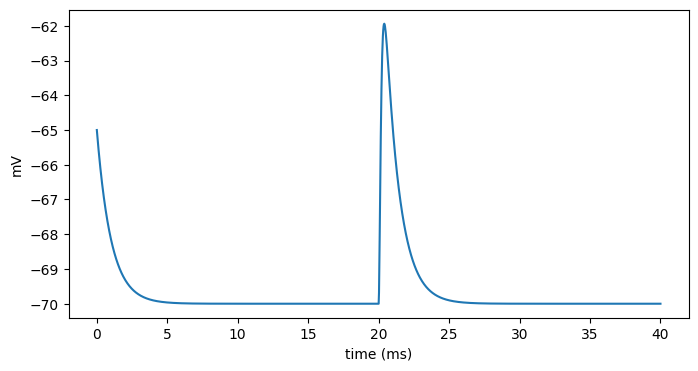

In [9]:
from matplotlib import pyplot
pyplot.figure(figsize=(8,4)) # Default figsize is (8,6)
pyplot.plot(t_vec, v_vec)
pyplot.xlabel('time (ms)')
pyplot.ylabel('mV')
pyplot.show()

In [10]:
import pickle 
with open('t_vec.p', 'wb') as t_vec_file:
    pickle.dump(t_vec, t_vec_file)
with open('v_vec.p', 'wb') as v_vec_file:
    pickle.dump(v_vec, v_vec_file)

In [11]:
from neuron.units import ms, mV

In [12]:
h.load_file('stdrun.hoc')


1.0

In [13]:
%matplotlib notebook

In [27]:
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._morphology()
        self.all = self.soma.wholetree()
        self._biophysics()
        self.x = self.y = self.z = 0 
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x,y, z)
        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               x - self.x + sec.x3d(i),
                               y - self.y + sec.y3d(i),
                               z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
        
    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))


In [28]:
class BallAndStick(Cell):
    name = 'BallandStick'
    def _morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
        
    def _biophysics(self):
        for sec in self.all: 
                sec.Ra  = 100 #axial resistance Ohm * cm
                sec.cm = 1 #membrane capacitance micro farads/cm^2
        
        #active currents
        self.soma.insert('hh') #applying hodgkin huxley biophysical constrains
        for seg in self.soma: 
            
            #S/cm^2
            seg.hh.gnabar = 0.12 #na conductance
            seg.hh.gkbar = 0.036 #k conductance
            seg.hh.gl = 0.003 #leak conductance
            
            seg.hh.el = -54.3 #reversal potential, mV
        
        #passive currrents
        self.dend.insert('pas')
        for seg in self.dend:
            seg.pas.g = 0.001
            seg.pas.e = -65

In [29]:
def create_n_bs(n,r):
    '''n = number of cells, r = radius'''
    cells = []
    for i in range(n):
        theta = i*2*h.PI/n
        cells.append(BallAndStick(i, h.cos(theta)*r, h.sin(theta)*r, 0, theta))
    return cells

In [30]:
my_cells = create_n_bs(7, 50)

In [31]:
ps = h.PlotShape(True)
ps.show(0)

1.0

In [32]:
my_cells = create_n_bs(5, 50)


In [35]:
stim = h.NetStim()

syn_ = h.ExpSyn(my_cells[0].dend(0.5))

stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1*ms
ncstim.weight[0] = 0.04 #netcon weight

syn_.tau = 2 * ms
print("Rev. potential = {} mV".format(syn_.e))

Rev. potential = 0.0 mV


In [36]:
recording_cell = my_cells[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

<IPython.core.display.Javascript object>


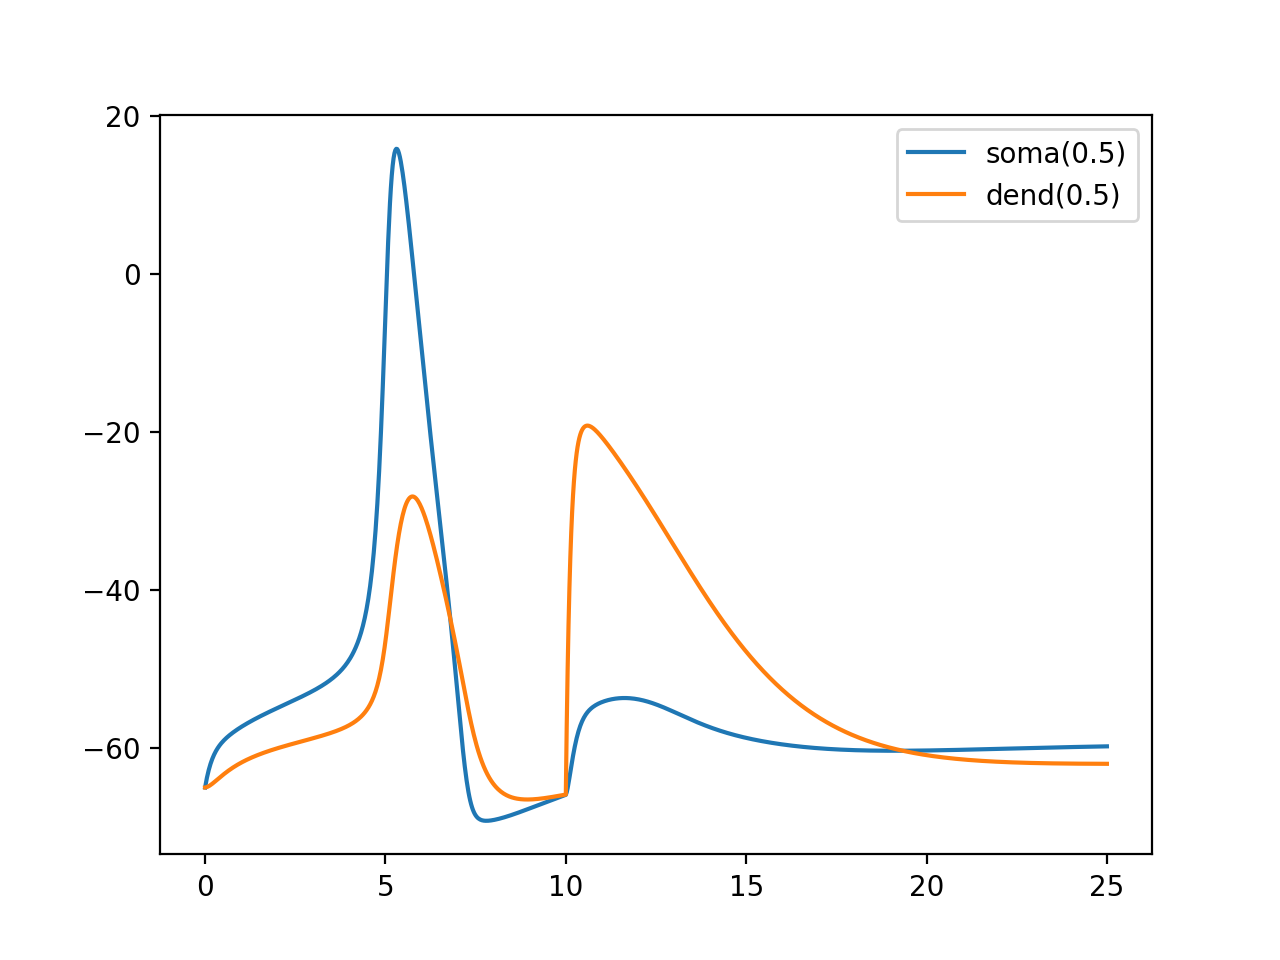

In [37]:
import matplotlib.pyplot as plt
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


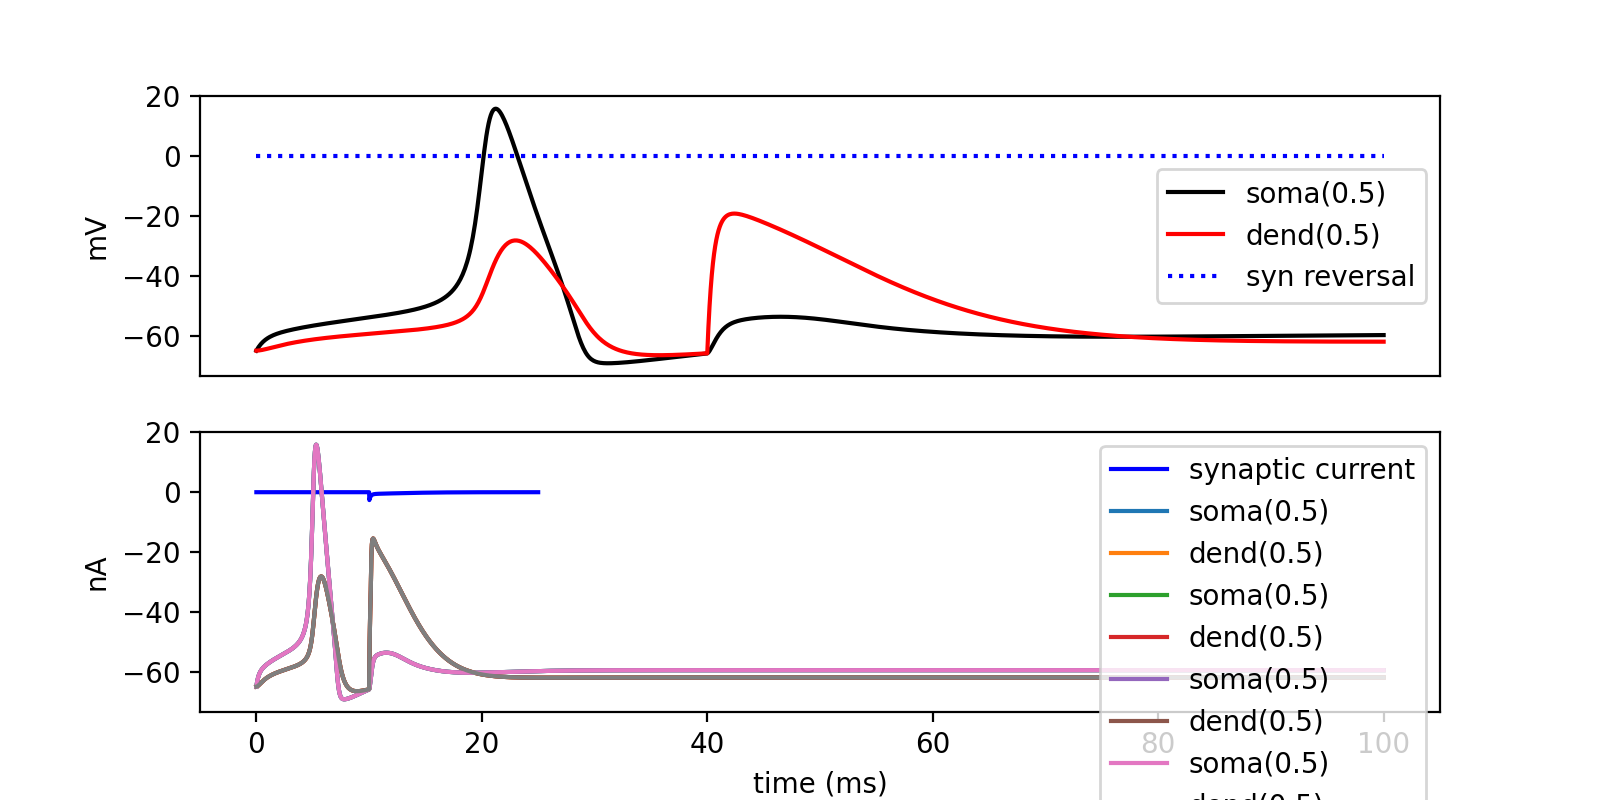

In [38]:
syn_i = h.Vector().record(syn_._ref_i)
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(2, 1, 1)
soma_plot = ax1.plot(t, soma_v, color='black', label='soma(0.5)')
dend_plot = ax1.plot(t, dend_v, color='red', label='dend(0.5)')
rev_plot = ax1.plot([t[0], t[-1]], [syn_.e, syn_.e], label='syn reversal',
        color='blue', linestyle=':')
ax1.legend()
ax1.set_ylabel('mV')
ax1.set_xticks([]) # Use ax2's tick labels

ax2 = fig.add_subplot(2, 1, 2)
syn_plot = ax2.plot(t, syn_i, color='blue', label='synaptic current')
ax2.legend()
ax2.set_ylabel(h.units('ExpSyn.i'))
ax2.set_xlabel('time (ms)')
plt.show()

In [43]:
syns = []
netcons = []
for source, target in zip(my_cells, my_cells[1:] + [my_cells[0]]):
    syn = h.ExpSyn(target.dend(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.weight[0] = 0.05
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)
    


In [44]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

In [46]:
spike_times = [h.Vector() for nc in netcons]
for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)

h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

In [47]:
for i, spike_times_vec in enumerate(spike_times):
    print('cell {}: {}'.format(i, list(spike_times_vec)))

cell 0: [5.150000000100039]
cell 1: [5.150000000100039]
cell 2: [5.150000000100039]
cell 3: [5.150000000100039]
cell 4: [5.150000000100039]


In [ ]:
import matplotlib.pyplot as plt
plt.figure()

for i, spike_times_vec in enumerate(spike_times):
    plt.vlines(spike_times_vec, i + 0.5, i + 1.5)
plt.show()